Reproducing the InvalidArgumentError:  Found a Pauli sum operating on qubits not found in circuit.
	 [[node model_70/expectation_70/TfqSimulateExpectation (defined at <string>:69) ]] [Op:__inference_distributed_function_52361]
  

In [1]:
import numpy as np
import sympy
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq

In [2]:
qubits = cirq.GridQubit.rect(1, 3)
circuit = cirq.Circuit()
symbols=[]
for k in range(3):
    sy=sympy.Symbol(str(k))
    symbols.append(str(k))
    circuit += cirq.ry(sy)(qubits[k])


In [3]:
circuit

(0, 0): ───Ry(0)───

(0, 1): ───Ry(1)───

(0, 2): ───Ry(2)───

In [4]:
params=np.random.sample(3)
resolver = {k: v for k, v in zip(symbols, params)}
cirq.resolve_parameters(circuit,resolver)

(0, 0): ───Ry(0.033π)───

(0, 1): ───Ry(0.245π)───

(0, 2): ───Ry(0.04π)────

In [5]:
op = cirq.Z(qubits[0])
op_target = tfq.convert_to_tensor([[op]])

In [6]:
circuit_input = tf.keras.Input(shape=(), dtype=tf.string)
output = tfq.layers.Expectation()(
        circuit_input,
        symbol_names=symbols,
        operators=op_target,
        initializer=tf.keras.initializers.RandomNormal())

output = tf.math.reduce_sum(output, axis=-1, keepdims=True)
model = tf.keras.Model(inputs=circuit_input, outputs=output)

In [7]:
model.get_weights()

[array([ 0.03017755, -0.03555817,  0.04816406], dtype=float32)]

In [8]:
tcircquit = tfq.convert_to_tensor([circuit])
model(tcircquit)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9995445]], dtype=float32)>

In [9]:
resolver = {k: v for k, v in zip(symbols, model.get_weights()[0])}
cirq.resolve_parameters(circuit,resolver)

(0, 0): ───Ry(0.01π)─────

(0, 1): ───Ry(-0.011π)───

(0, 2): ───Ry(0.015π)────

In [10]:
cirq.unitary(cirq.ry(model.get_weights()[0][0])(qubits[0]))

array([[ 0.99988617+0.j, -0.0150882 +0.j],
       [ 0.0150882 +0.j,  0.99988617+0.j]])

In [35]:
expectation = tfq.layers.Expectation()
circuit_tensor = tfq.convert_to_tensor([circuit])
values_tensor = tf.convert_to_tensor(np.random.uniform(0, 2 * np.pi, (1, 3)).astype(np.float32))

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.01)

In [42]:
with tf.GradientTape() as g:
        g.watch(values_tensor)
        ex = expectation(circuit_tensor,
                    operators=tfq.convert_to_tensor([[op]]),
                    symbol_names=symbols,
                    symbol_values=values_tensor
                   )
        grads = g.gradient(ex, values_tensor)


In [44]:
grads

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.43461037, -0.00211143, -0.04018784]], dtype=float32)>

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.7763568e-15]], dtype=float32)>

In [35]:
q = cirq.GridQubit(0, 0)
(a, b, c) = sympy.symbols("a b c")
circuit = cirq.Circuit(
    cirq.rz(a)(q),
    cirq.rx(b)(q),
    cirq.rz(c)(q),
    cirq.rx(-b)(q),
    cirq.rz(-a)(q)
)

In [36]:
circuit

(0, 0): ───Rz(a)───Rx(b)───Rz(c)───Rx(-b)───Rz(-a)───

In [37]:
measurement = [cirq.X(q), cirq.Y(q), cirq.Z(q)]

In [38]:
outputs = tfq.layers.PQC(
    circuit,
    measurement)

In [46]:
quantum_data = tfq.convert_to_tensor([
    cirq.Circuit(),
    cirq.Circuit(cirq.X(q))
])

In [40]:
res = outputs(quantum_data)
res

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.6003571 , 0.67087144, 0.43531922],
       [0.6003571 , 0.67087144, 0.43531922]], dtype=float32)>

In [42]:
outputs.get_weights()[0]

array([5.1807814, 1.9618783, 1.2246035], dtype=float32)

CONTROLLED PQC

In [51]:
bit = cirq.GridQubit(0, 0)
(a, b, c) = sympy.symbols("a b c")
model = cirq.Circuit(
    cirq.rz(a)(q),
    cirq.rx(b)(q),
    cirq.rz(c)(q),
    cirq.rx(-b)(q),
    cirq.rz(-a)(q)
)
outputsc = tfq.layers.ControlledPQC(model,  [cirq.X(bit), cirq.Y(bit), cirq.Z(bit)])
quantum_data = tfq.convert_to_tensor([
    cirq.Circuit(),
    cirq.Circuit(cirq.X(bit))
])
model_params = tf.convert_to_tensor([outputs.get_weights()[0], outputs.get_weights()[0]])
res = outputsc([quantum_data, model_params])
res

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 0.6003571 ,  0.67087144,  0.43531922],
       [-0.6003571 , -0.67087126, -0.4353191 ]], dtype=float32)>

In [49]:
outputsc.get_weights()

[]

EXPECTATION

In [52]:
def _gen_single_bit_rotation_problem(bit, symbols):
    """Generate a toy problem on 1 qubit."""
    starting_state = [0.123, 0.456, 0.789]
    circuit = cirq.Circuit(
        cirq.rx(starting_state[0])(bit),
        cirq.ry(starting_state[1])(bit),
        cirq.rz(starting_state[2])(bit),
        cirq.rz(symbols[2])(bit),
        cirq.ry(symbols[1])(bit),
        cirq.rx(symbols[0])(bit)
    )
    return circuit


In [55]:
bit = cirq.GridQubit(0, 0)
symbols = sympy.symbols('x, y, z')
ops = [-1.0 * cirq.Z(bit), cirq.X(bit) + 2.0 * cirq.Z(bit)]
circuit_list = [
    _gen_single_bit_rotation_problem(bit, symbols),
    cirq.Circuit(
        cirq.Z(bit) ** symbols[0],
        cirq.X(bit) ** symbols[1],
        cirq.Z(bit) ** symbols[2]
    ),
    cirq.Circuit(
        cirq.X(bit) ** symbols[0],
        cirq.Z(bit) ** symbols[1],
        cirq.X(bit) ** symbols[2]
    )
]
# Here output[i][j] corresponds to the expectation of all the ops
# in ops w.r.t circuits[i] where keras managed variables are
# placed in the symbols 'x', 'y', 'z'.

expectation_layer = tfq.layers.Expectation()
output = expectation_layer(
    circuit_list, symbol_names=symbols, operators = ops)
output

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 0.2499863 , -1.375679  ],
       [ 0.19183385, -0.77835333],
       [ 0.897941  , -1.5080712 ]], dtype=float32)>

In [56]:
expectation_layer.get_weights()

[array([6.094739 , 4.5614433, 1.1317385], dtype=float32)]

In [57]:
circuit_list[0]

(0, 0): ───Rx(0.039π)───Ry(0.145π)───Rz(0.251π)───Rz(z)───Ry(y)───Rx(x)───

In [58]:
circuit_list[1]

(0, 0): ───Z^x───X^y───Z^z───

In [59]:
circuit_list[2]

(0, 0): ───X^x───Z^y───X^z───

In [60]:
bit = cirq.GridQubit(0, 0)
symbols = sympy.symbols('x, y, z')
ops = [-1.0 * cirq.Z(bit), cirq.X(bit) + 2.0 * cirq.Z(bit)]
fixed_circuit = _gen_single_bit_rotation_problem(bit, symbols)
expectation_layer = tfq.layers.Expectation()
output = expectation_layer(
    fixed_circuit,
    symbol_names=symbols,
    operators=ops,
    initializer=tf.keras.initializers.RandomUniform(0, 2 * np.pi))
# Here output[i][j] corresponds to
# the expectation of operators[i][j] w.r.t the circuit where
# variable values are managed by keras and store numbers in
# the symbols 'x', 'y', 'z'.
tf.shape(output)


<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 2], dtype=int32)>

In [61]:
fixed_circuit

(0, 0): ───Rx(0.039π)───Ry(0.145π)───Rz(0.251π)───Rz(z)───Ry(y)───Rx(x)───

In [62]:
expectation_layer.get_weights()

[array([4.1837454, 3.8032973, 1.2957823], dtype=float32)]

In [63]:
output

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.00733591, -0.44760728]], dtype=float32)>

 Lastly you also supplied a tf.keras.initializer to the initializer argument. This argument is optional in the case that the layer itself will be managing the symbols of the circuit and not have them fed in from somewhere else in the model.

symbol_values

In [66]:
bit = cirq.GridQubit(0, 0)
symbols = sympy.symbols('x, y, z')
ops = [cirq.Z(bit), cirq.X(bit)]
circuit = _gen_single_bit_rotation_problem(bit, symbols)
values = [[1,1,1], [2,2,2], [3,3,3]]
expectation_layer = tfq.layers.Expectation()
output = expectation_layer(
    circuit,
    symbol_names=symbols,
    symbol_values=values,
    operators=ops)
# output[i][j] = The expectation of operators[j] with
# values[i] placed into the symbols of the circuit
# with the order specified by symbol_names.
# so output[1][2] = The expectation of your circuit with parameter
# values [2,2,2] w.r.t Pauli X.
output


<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.6300524 , 0.76338404],
       [0.2570717 , 0.9632684 ],
       [0.79086655, 0.5441111 ]], dtype=float32)>

In [65]:
expectation_layer.get_weights()

[]

Undo rotation!

In [71]:
bit = cirq.GridQubit(0, 0)
symbols = sympy.symbols('x, y, z')
circuit = _gen_single_bit_rotation_problem(bit, symbols)
control_input = tf.keras.Input(shape=(1,))
circuit_inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
d1 = tf.keras.layers.Dense(10)(control_input)
d2 = tf.keras.layers.Dense(3)(d1)
expectation = tfq.layers.Expectation()(
    circuit_inputs, # See note below!
    symbol_names=symbols,
    symbol_values=d2,
    operators=cirq.Z(bit))
data_in = np.array([[1], [0]], dtype=np.float32)
data_out = np.array([[1], [-1]], dtype=np.float32)
model = tf.keras.Model(
    inputs=[circuit_inputs, control_input], outputs=expectation)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.mean_squared_error)
history = model.fit(
    x=[tfq.convert_to_tensor([circuit] * 2), data_in],
    y=data_out,
    epochs=100, verbose=0)


In [97]:
model([tfq.convert_to_tensor([circuit] * 2), data_in])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 0.9914125],
       [-0.9948326]], dtype=float32)>

In [96]:
model(circuit)

KeyError: '139975151777776'

In [81]:
model.get_weights()[-1]

array([-0.34636295,  0.20388007,  0.45487836], dtype=float32)

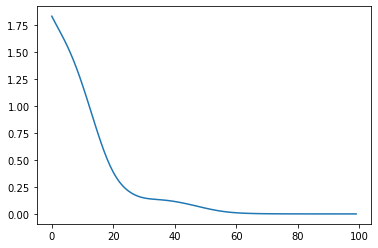

In [92]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])

In [196]:

class CirqSolver:
    def __init__(self, n_qubits=3, observable=None):
        self.name = "CirqSolver"
        self.n_qubits = n_qubits
        self.observable=observable #careful here!
        self.qubits = cirq.GridQubit.rect(1, n_qubits)
        self.alphabet = {"0":{"gate": cirq.X, "wires": [2]},
                            "1":{"gate": cirq.rz, "wires": [0]},
                            "2":{"gate": cirq.ry, "wires": [1]},
                            "3":{"gate": cirq.CNOT, "wires": [1,2]},#, "params":[np.pi]},
                            "4":{"gate": cirq.CNOT, "wires": [1,0]},#, "params":[np.pi]},
                            "5":{"gate": cirq.ry, "wires": [0]},
                            "6":{"gate":cirq.rz, "wires":[0]},#optimal sequence will be larger..
                            "7":{"gate": cirq.CNOT, "wires": [0,1]},#, "params":[np.pi]},
                           }

        self.parametrized = [cirq.rz, cirq.ry, cirq.rx]
        if observable is None:  # then take projector on W state
            sq = 1 / np.sqrt(3)
            w_state = np.array([0, sq, sq, 0, sq, 0, 0, 0])
            w_proj = cirq.density_matrix_from_state_vector(w_state)
            self.observable_matrix = w_proj
            self.observable = self.cirq_friendly_observable(w_proj)



    def cirq_friendly_observable(self, obs):
        PAULI_BASIS = {
            'I': np.eye(2),
            'X': np.array([[0., 1.], [1., 0.]]),
            'Y': np.array([[0., -1j], [1j, 0.]]),
            'Z': np.diag([1., -1]),
        }

        pauli3 = cirq.linalg.operator_spaces.kron_bases(PAULI_BASIS, repeat=3)
        decomp = cirq.linalg.operator_spaces.expand_matrix_in_orthogonal_basis(obs, pauli3) #notice it's not required to be orthonormal!

        PAULI_BASIS_CIRQ = {
            'I': cirq.X,
            'X': cirq.X,
            'Y': cirq.Y,
            'Z': cirq.Z,
        }

        unt = []
        for term in decomp.items():
            gate_name = term[0]
            coeff = term[1]
            s=0
            ot=float(coeff)
            for qpos, single_gate in enumerate(gate_name):
                if single_gate == "I":
                    ot*=PAULI_BASIS_CIRQ[single_gate](self.qubits[qpos])*PAULI_BASIS_CIRQ[single_gate](self.qubits[qpos])
                else:
                    ot*=PAULI_BASIS_CIRQ[single_gate](self.qubits[qpos])
            if s<3:
                unt.append(ot)
        return unt
    #
    #

    def vansatz_keras_model(self, vansatz, observable):
        #notice observable may in general be expressed as linear combination
        #of different elements  on orthonormal basis obtained from tensor product
        #of SU(2) generators. tf.math.reduce_sum is in charge of taking this linear combination.
        circuit_input = tf.keras.Input(shape=(), dtype=tf.string)
        output = tfq.layers.Expectation()(
                circuit_input,
                symbol_names=vansatz.symbols,
                operators=tfq.convert_to_tensor([observable]),
                initializer=tf.keras.initializers.RandomNormal())

        output = tf.math.reduce_sum(output, axis=-1, keepdims=True)

        model = tf.keras.Model(inputs=circuit_input, outputs=output)
        adam = tf.keras.optimizers.Adam(learning_rate=0.1)
        model.compile(optimizer=adam, loss='mse')
        return model

    def run_circuit(self, list_ops):
        wst = VAnsatz(list_ops)
        print(list_ops)
        if (wst.symbols == [])|(wst.cnots<1):
            simulator = cirq.Simulator()
            result = simulator.simulate(wst.get_state(self.qubits, params=np.random.sample(len(wst.symbols))), qubit_order=self.qubits)
            energy = np.trace(np.dot(wst.observable_matrix, cirq.density_matrix_from_state_vector(result.final_state))).real
            probs = np.abs(result.final_state)**2
            return energy, probs
        
        model = self.vansatz_keras_model(wst, self.observable)
        w_input = tfq.convert_to_tensor([wst.circuit])
        w_output = tf.ones((1,1)) #in case of W_state we want fidelity 1.
        print("estoy aquii")
        
        model.fit(x=w_input, y=w_output, batch_size=1, epochs=50,
                    verbose=0)
        energy = float(np.squeeze(model.predict(w_input)))

        simulator = cirq.Simulator()
        result = simulator.simulate(wst.get_state(self.qubits,params=model.get_weights()[0]), qubit_order=self.qubits)
        probs = np.abs(result.final_state)**2
        return energy, probs



class VAnsatz(CirqSolver):
    def __init__(self, trajectory):
        super(VAnsatz, self).__init__()
        self.cnots = 0
        param_ind=0
        gates=[]
        wires=[]
        params_cirquit=[]
        parhere=[]
        self.symbols=[]
        for gate_ind in trajectory:
            g = self.alphabet[str(int(gate_ind))]["gate"]
            wires.append(self.alphabet[str(int(gate_ind))]["wires"])
            if g in self.parametrized: #assuming is one qubit unitary
                symbol = "x_{}".format(param_ind)
                self.symbols.append(symbol)
                params_cirquit.append(sympy.Symbol(self.symbols[-1]))
                param_ind+=1
                gates.append(g(params_cirquit[-1]))
                parhere.append(True)
            else:
                if g == cirq.CNOT:
                    self.cnots+=1
                gates.append(g)
                parhere.append(False)
        self.wires = wires
        self._gates=gates
        self.parhere =parhere
        self.circuit=self.get_state(self.qubits)

    def get_state(self, qubits, params=None):
        circuit = cirq.Circuit()
        cc=[]
        for ind, g in enumerate(self._gates):
            if len(self.wires[ind])==1:
                indqub = self.wires[ind][0]
                cc.append(g(qubits[indqub]))
            else:
                control, target = self.wires[ind]
                cc.append(g(qubits[control], qubits[target]))
        circuit.append(cc)
        self.ac = cc
        if params is None:
            return circuit
        resolver = {k: v for k, v in zip(self.symbols, params)}
        return cirq.resolve_parameters(circuit, resolver)



print(solver.alphabet)


{'0': {'gate': cirq.X, 'wires': [2]}, '1': {'gate': <function rz at 0x7f4ed88869d8>, 'wires': [0]}, '2': {'gate': <function ry at 0x7f4ed88867b8>, 'wires': [1]}, '3': {'gate': cirq.CNOT, 'wires': [1, 2]}, '4': {'gate': cirq.CNOT, 'wires': [1, 0]}, '5': {'gate': <function ry at 0x7f4ed88867b8>, 'wires': [0]}, '6': {'gate': <function rz at 0x7f4ed88869d8>, 'wires': [0]}, '7': {'gate': cirq.CNOT, 'wires': [0, 1]}}


In [153]:
solver = CirqSolver()
print(solver.run_circuit(np.array([5.,4.])))

/home/cooper-cooper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part


[5. 4.]
estoy aquii


InvalidArgumentError:  Found a Pauli sum operating on qubits not found in circuit.
	 [[node model_70/expectation_70/TfqSimulateExpectation (defined at <string>:69) ]] [Op:__inference_distributed_function_52361]

Errors may have originated from an input operation.
Input Source operations connected to node model_70/expectation_70/TfqSimulateExpectation:
 model_70/expectation_70/Const (defined at /home/cooper-cooper/.local/lib/python3.6/site-packages/tensorflow_quantum/python/layers/circuit_executors/input_checks.py:65)	
 IteratorGetNext (defined at <ipython-input-152-e8b90145c8b0>:104)	
 model_70/expectation_70/Tile_1 (defined at /home/cooper-cooper/.local/lib/python3.6/site-packages/tensorflow_quantum/python/layers/circuit_executors/expectation.py:288)	
 model_70/expectation_70/52198 (defined at /home/cooper-cooper/.local/lib/python3.6/site-packages/tensorflow_quantum/python/layers/circuit_executors/expectation.py:291)

Function call stack:
distributed_function


In [197]:
solver = CirqSolver()
print(solver.run_circuit(np.array([7,1])))

/home/cooper-cooper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part


[7 1]
estoy aquii


InvalidArgumentError:  Found a Pauli sum operating on qubits not found in circuit.
	 [[{{node PartitionedCall/TfqSimulateExpectation}}]] [Op:__inference_distributed_function_61487]

Function call stack:
distributed_function


In [166]:
solver.alphabet

{'0': {'gate': cirq.X, 'wires': [2]},
 '1': {'gate': <function cirq.ops.common_gates.rz(rads:Union[float, sympy.core.basic.Basic]) -> cirq.ops.common_gates.ZPowGate>,
  'wires': [0]},
 '2': {'gate': <function cirq.ops.common_gates.ry(rads:Union[float, sympy.core.basic.Basic]) -> cirq.ops.common_gates.YPowGate>,
  'wires': [1]},
 '3': {'gate': cirq.CNOT, 'wires': [1, 2]},
 '4': {'gate': cirq.CNOT, 'wires': [1, 0]},
 '5': {'gate': <function cirq.ops.common_gates.ry(rads:Union[float, sympy.core.basic.Basic]) -> cirq.ops.common_gates.YPowGate>,
  'wires': [0]},
 '6': {'gate': <function cirq.ops.common_gates.rz(rads:Union[float, sympy.core.basic.Basic]) -> cirq.ops.common_gates.ZPowGate>,
  'wires': [0]},
 '7': {'gate': cirq.CNOT, 'wires': [0, 1]}}

In [163]:
t=np.array([5,4])
ww = VAnsatz(t)
ww.symbols

/home/cooper-cooper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: ComplexWarning: Casting complex values to real discards the imaginary part


['x_0']

In [ ]:
ww.

In [164]:
ww.get_state(ww.qubits, np.random.sample(1))

(0, 0): ───Ry(0.142π)───X───
                        │
(0, 1): ────────────────@───

In [165]:
model = solver.vansatz_keras_model(ww, solver.observable)
w_input = tfq.convert_to_tensor([ww.circuit])
print(model(w_input), model.get_weights())
w_output = tf.ones((1,1)) #in case of W_state we want fidelity 1.
model.fit(x=w_input, y=w_output, batch_size=1, epochs=50,verbose=0)
print(model(w_input), model.get_weights())

InvalidArgumentError: Found a Pauli sum operating on qubits not found in circuit. [Op:TfqSimulateExpectation]

In [162]:
simulator = cirq.Simulator()
result = simulator.simulate(wst.get_state(ww.qubits,params=model.get_weights()[0]), qubit_order=ww.qubits)
result

measurements: (no measurements)
output vector: (0.991+0.132j)|000⟩